---
# Imports

In [1]:
# imports.py
from imports import *
from sklearn.datasets import make_blobs

# plotting magic
%matplotlib inline

# custom mods
import tidy
import model_h
import wrangle

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


---
# Wrangle

In [2]:
df=wrangle.wrangle_df()
# df.info()
# # model_h.print_btcusd(df)
# df.head()

cached csv


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2770 entries, 2014-10-20 to 2022-05-24
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   open                          2770 non-null   float64
 1   high                          2770 non-null   float64
 2   low                           2770 non-null   float64
 3   close                         2770 non-null   float64
 4   volume                        2770 non-null   float64
 5   fwd_log_ret                   2770 non-null   float64
 6   fwd_ret                       2770 non-null   float64
 7   fwd_pct_chg                   2770 non-null   float64
 8   fwd_close_positive            2770 non-null   float64
 9   macd                          2770 non-null   float64
 10  signal                        2770 non-null   float64
 11  histo                         2770 non-null   float64
 12  cross                         2770 non-null 

---
## Xy Split

In [5]:
X=df[['open', 'high', 'low', 'close', 'volume', 'obv_close_product', 'macd', 'signal', 'histo', 'cross', 'histy', 'atr_above_threshold_0.01',
       'atr_above_threshold_0.05', 'atr_above_threshold_0.1',
       'atr_above_threshold_0.2', 'atr_above_threshold_0.3','sentiment']]

In [7]:
y=df[['fwd_log_ret', 'fwd_ret', 'fwd_pct_chg', 'fwd_close_positive']]

---
## Train / Validate Split

In [8]:
X_train, X_val=tidy.split_i(X)
y_train, y_val=tidy.split_i(y)

# # train_ii, test=tidy.split_ii(df)
# # train_ii.info(),test.info()


In [10]:
X_train[['cross','histy']]=X_train[['cross','histy']].astype('int')

/var/folders/mk/w2hz4wxx7xn5hr_56wz536gh0000gn/T/ipykernel_74705/4005747211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['cross','histy']]=X_train[['cross','histy']].astype('int')


---
## Scaler

In [14]:
for col in X_train.columns:
	if X_train[col].dtype == 'float64':
		xs=np.array(X_train[[col]]).reshape(-1, 1)
		X_train.loc[:,col]=RobustScaler().fit_transform(xs)
		print(col)


open
high
low
close
volume
obv_close_product
macd
signal
histo
sentiment


/var/folders/mk/w2hz4wxx7xn5hr_56wz536gh0000gn/T/ipykernel_74705/1090873265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,col]=RobustScaler().fit_transform(xs)
/var/folders/mk/w2hz4wxx7xn5hr_56wz536gh0000gn/T/ipykernel_74705/1090873265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,col]=RobustScaler().fit_transform(xs)
/var/folders/mk/w2hz4wxx7xn5hr_56wz536gh0000gn/T/ipykernel_74705/1090873265.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

---
# RFE Regression

In [39]:
lm = LinearRegression()
rfe = RFE(lm, n_features_to_select=10)
# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train.fwd_ret)  
mask=rfe.support_
rfe_features = X_train.loc[:,mask].columns.tolist()

X_train=pd.DataFrame(X_rfe,columns=rfe_features)
X_val=pd.DataFrame(X_val,columns=rfe_features)



In [41]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32 entries, 2022-03-23 to 2022-04-23
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   open                      32 non-null     float64
 1   high                      32 non-null     float64
 2   low                       32 non-null     float64
 3   close                     32 non-null     float64
 4   volume                    32 non-null     float64
 5   obv_close_product         32 non-null     float64
 6   atr_above_threshold_0.01  32 non-null     object 
 7   atr_above_threshold_0.05  32 non-null     object 
 8   atr_above_threshold_0.1   32 non-null     object 
 9   atr_above_threshold_0.2   32 non-null     object 
dtypes: float64(6), object(4)
memory usage: 2.8+ KB


In [42]:

line=lm.fit(X_train,y_train.fwd_ret)


y_train['reg'] = lm.predict(X_train)
y_val['reg'] = lm.predict(X_val)


rmse_train = metrics.mean_squared_error(y_train.fwd_ret, y_train.reg)**(1/2)
rmse_validate = metrics.mean_squared_error(y_val.fwd_ret, y_val.reg)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  791.0300049733676 
Validation/Out-of-Sample:  1292631091405.6194


/var/folders/mk/w2hz4wxx7xn5hr_56wz536gh0000gn/T/ipykernel_74705/2726776167.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['reg'] = lm.predict(X_train)
/var/folders/mk/w2hz4wxx7xn5hr_56wz536gh0000gn/T/ipykernel_74705/2726776167.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_val['reg'] = lm.predict(X_val)


<AxesSubplot:>

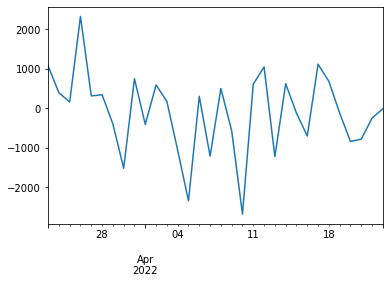

In [45]:

y_val.fwd_ret.plot()

---
# Clustering

In [ ]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


In [ ]:

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

In [ ]:
y_train.head()

In [ ]:

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train.fwd_close_positive, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_train.fwd_close_positive, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train.fwd_close_positive, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y_train.fwd_close_positive, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(y_train.fwd_close_positive, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, labels))

In [ ]:
np.argwhere(np.isnan(labels))

In [ ]:
labels=pd.DataFrame(labels,columns=['clust'],dtype='int',index=X_train.index)

In [ ]:
labels.info()

In [ ]:
type(labels.clust.iloc[0])

In [ ]:
type(X_train.open.iloc[0])

In [ ]:
X_train.info()

In [ ]:
X_train=pd.concat([X_train,labels],axis=1)

In [ ]:
xt=X_train.loc['2018':'2021']

In [ ]:
sns.relplot(x=X_train.loc['2018':'2021'].index, y=X_train.loc['2018':'2021'].close, hue=X_train.loc['2018':'2021'].clust)

In [ ]:
X_train.head()

In [ ]:
X_train=X_train.drop('clust',axis=1)